## 1. Импорт библиотек и настройка параметров

In [179]:
#!pip install requests 
#!pip install fake-useragent
#!pip install beautifulsoup4 

In [184]:
# Импортируем библиотеки:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import os
import re
from bs4 import BeautifulSoup
from fake_useragent import UserAgent 
from pprint import pprint

In [107]:
# Фиксируем параметры для воспроизводимости экспериментов:

RANDOM_SEED = 42
!pip freeze > requirements.txt

In [108]:
# Увеличиваем число отображаемых строк и столбцов в pandas:

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [109]:
# Задаем дирректорию для работы с файлами:

# При выполнении на kaggle раскомментировать этот блок:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
# PATH_to_file = '/kaggle/input/sf-dst-scoring/'

# При выполнении локально раскомментировать этот блок:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = './data/'

./data/test.csv
./data/sample_submission.csv


## 2. Анализ тестового датасета

Прежде чем начать парсить auto.ru, что-бысоздавать датасет для тренировки модели, посмотрим на наш тестовый датасет, стоимость автомобилей которого нам надо будет предсказывать.

In [110]:
# Загрузим наш тестовый датасет:

test = pd.read_csv(PATH_to_file + 'test.csv')

print('Размер тестового датасета: ', test.shape)
display(test.sample(5))

Размер тестового датасета:  (34686, 32)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
15336,седан,INFINITI,https://auto.ru/cars/used/sale/infiniti/m/1099...,чёрный,NaN,Сигнализация с мобильным приложением и автозап...,3.7 LTR,333 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,120000,2010,"{""code"":""M"",""name"":""M"",""ru_name"":""M"",""morpholo...",M,M37 3.7 AT (333 л.с.) 4WD,4,1603285685,RUB,2011,1099900436,"{""id"":""6418759"",""name"":""37"",""nameplate"":""M37"",...",SEDAN AUTOMATIC 3.7,автоматическая,JAPANESE,3 или более,3 года и 7 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен
14148,седан,NISSAN,https://auto.ru/cars/used/sale/nissan/primera/...,серебристый,NaN,Пишите в чат или what app,2.0 LTR,150 N12,NaN,бензин,https://autoru.naydex.net/G87gDZg56/28c7a8vqVE...,250000,2001,"{""code"":""PRIMERA"",""name"":""Primera"",""ru_name"":""...",PRIMERA,2.0 CVT (150 л.с.),4,1603281134,RUB,2005,1100227526,"{""id"":""8298950"",""displacement"":1998,""engine_ty...",SEDAN VARIATOR 2.0,вариатор,JAPANESE,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен
24761,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/jett...,зелёный,NaN,Комплект зимних шин в подарок. Своевременное о...,1.6 LTR,102 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,142000,2005,"{""code"":""JETTA"",""name"":""Jetta"",""ru_name"":""Джет...",JETTA,1.6 AT (102 л.с.),4,1603218800,RUB,2008,1101264716,"{""id"":""20399654"",""displacement"":1595,""engine_t...",SEDAN AUTOMATIC 1.6,автоматическая,EUROPEAN,3 или более,3 года и 5 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен
22455,внедорожник 5 дв.,LEXUS,https://auto.ru/cars/used/sale/lexus/gx/110132...,чёрный,NaN,"В отличном состоянии, без ДТП, все оригинал",4.7 LTR,270 N12,NaN,бензин,https://autoru.naydex.net/imflT9272/520f62I9/2...,185000,2002,"{""code"":""GX"",""name"":""GX"",""ru_name"":""GX"",""morph...",GX,470 4.7 AT (270 л.с.) 4WD,5,1603299405,RUB,2007,1101321761,"{""id"":""20393579"",""name"":""470"",""nameplate"":""470...",ALLROAD_5_DOORS AUTOMATIC 4.7,автоматическая,JAPANESE,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
22749,внедорожник 5 дв.,LEXUS,https://auto.ru/cars/used/sale/lexus/lx/109029...,чёрный,NaN,Продается автомобиль в хорошем состоянии для с...,4.7 LTR,234 N12,NaN,бензин,https://autoru.naydex.net/imflT9272/520f62I9/2...,180000,1998,"{""code"":""LX"",""name"":""LX"",""ru_name"":""LX"",""morph...",LX,470 4.7 AT (234 л.с.) 4WD,5,1603300540,RUB,2002,1090293516,"{""id"":""5139969"",""name"":""470"",""nameplate"":""470""...",ALLROAD_5_DOORS AUTOMATIC 4.7,автоматическая,JAPANESE,3 или более,2 года и 5 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен


### 2.1 Первый взгляд

In [111]:
# Посмотрим информацию по столбцам нашего датадасета:

display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

None

In [112]:
# В датасете присутствуют названия столбцов на русском языке, а так-же трудно воспринимаемые, переименуем их:

test.columns = ['body_type', 'brand', 'car_url', 'color',
                'complectation', 'description', 'engine_volume',
                'engine_power', 'equipment', 'fuel_type', 'image',
                'mileage', 'model_date', 'model_info', 'model_name',
                'name', 'doors_num', 'parsing_unixtime', 'currency',
                'production_date', 'sell_id', 'super_gen', 'configuration',
                'transmission', 'vendor', 'owners_count', 'ownership',
                'docs', 'drive', 'steering', 'state', 'customs']

In [113]:
# Посмотрим на уникальные значения в каждом столбце:

test.nunique().sort_values()

customs                 1
currency                1
state                   1
steering                2
docs                    2
vendor                  2
drive                   3
owners_count            3
transmission            4
fuel_type               5
doors_num               5
brand                  12
color                  16
body_type              24
engine_volume          55
model_date             66
production_date        69
ownership             275
engine_power          315
model_name            544
configuration         634
model_info            954
complectation        2364
name                 2780
super_gen            5890
mileage             11268
equipment           23705
description         31732
image               34557
parsing_unixtime    34686
car_url             34686
sell_id             34686
dtype: int64

In [114]:
# В 3х столбцах у нас содержится по одному значению, а значит для модели они не нужны.
# Посмотрим на них:

test.sample(1)[['customs', 'currency', 'state']]

,customs,currency,state
20469,Растаможен,RUB,Не требует ремонта


In [115]:
# Все машины в нашей выборке растаможены, продаются за рубли и не требуют ремонта. 
# Соответствующие столбцы можно удалить:

test.drop(columns=['customs', 'currency', 'state'], inplace=True)

In [116]:
# Можно так-же удалить столбцы не несущие полезной для модели информации (id продавца, ссылку на объявление и изображения):

test.drop(columns=['sell_id', 'car_url', 'image'], inplace=True)

body_type               0
brand                   0
color                   0
complectation       28268
description             0
engine_volume           0
engine_power            0
equipment            9996
fuel_type               0
mileage                 0
model_date              0
model_info              0
model_name              0
name                    0
doors_num               0
parsing_unixtime        0
production_date         0
super_gen               0
configuration           0
transmission            0
vendor                  0
owners_count            0
ownership           22691
docs                    1
drive                   0
steering                0
dtype: int64

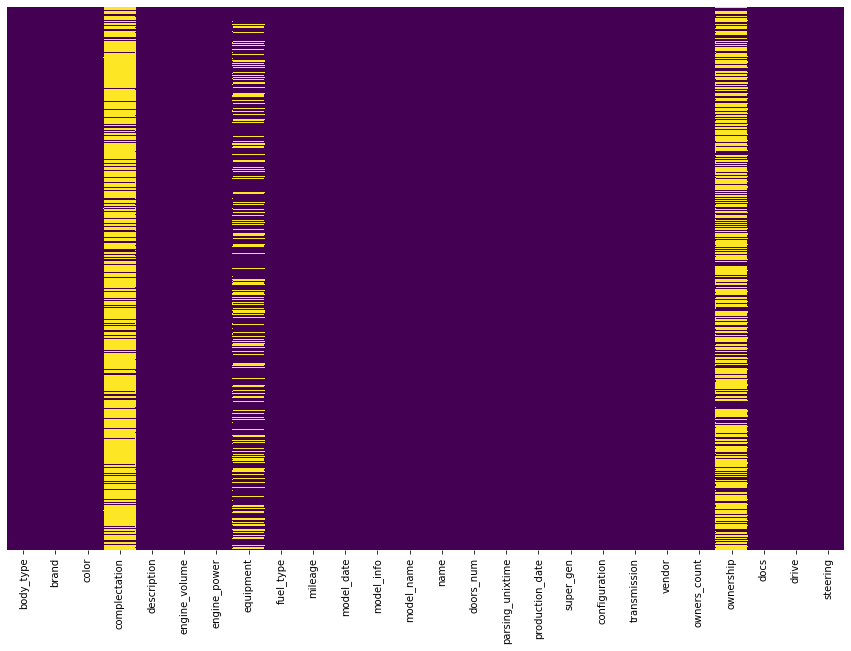

In [117]:
# Посмотрим кол-во пропусков в нашем датасете:

display(test.isna().sum())

plt.rcParams['figure.figsize'] = 15, 10
sns_heatmap = sns.heatmap(test.isnull(), yticklabels=False,
                          cbar=False, cmap='viridis')

### 2.2 Работа с признаками

#### 2.2.1 Бинарные переменные (steering, docs, vendor)

In [13]:
# Посмотрим как закодированы наши бинарные переменные:

for col in ['steering', 'docs', 'vendor']:
    print(f'Значения в колнке {col}: {test[col].unique()}')

Значения в колнке steering: ['Левый' 'Правый']
Значения в колнке docs: ['Оригинал' 'Дубликат' nan]
Значения в колнке vendor: ['EUROPEAN' 'JAPANESE']


In [118]:
# В нашем датасете присутствуют автомобили с (ВНЕЗАПНО! :)) правым и левым рулем, 
# Европейских или Японских марок, с (тоже ВНЕЗАПНО! :)) оригиналами и дубликатами ПТС.

# В признаке ПТС есть один пропуск, заполним его наиболее частым значением:

test.docs = test.docs.fillna(test.docs.value_counts().index[0])

In [119]:
# Теперь можно перевести наши бинарные столбцы в числовой формат. Пусть первое значение в столбце будет 0, второе 1:

for col in ['steering', 'docs', 'vendor']:
    test[col] = (test[col] == test[col].unique()[1]).astype('int')

#### 2.2.2 Категориаьные переменные (drive, owners_count, transmission, fuel_type, doors_num)

In [120]:
# Посмотрим какие значения принимают категориаьные переменные:

for col in ['drive', 'owners_count', 'transmission', 'fuel_type', 'doors_num']:
    print(f'Значения в колнке {col}: {test[col].unique()}')

Значения в колнке drive: ['передний' 'полный' 'задний']
Значения в колнке owners_count: ['3 или более' '1\xa0владелец' '2\xa0владельца']
Значения в колнке transmission: ['роботизированная' 'механическая' 'автоматическая' 'вариатор']
Значения в колнке fuel_type: ['бензин' 'дизель' 'гибрид' 'электро' 'газ']
Значения в колнке doors_num: [5 4 2 3 0]


In [121]:
# На данном этапе можно преобразовать значения в колонке owners_count, 
# т.к. по сути это числовая переменная, где число содержится в начале строки:

test.owners_count = test.owners_count.str[0].astype('int')

#### 2.2.3 Остальные столбцы

In [122]:
# При дальнейшем "осмотре" датасета можно обратить внимание на столбец configuration:

display(test.configuration.sample(5))

16441                SEDAN AUTOMATIC 2.0
2286        WAGON_5_DOORS MECHANICAL 1.3
27254               SEDAN MECHANICAL 1.3
7375                 SEDAN AUTOMATIC 2.4
31345    HATCHBACK_5_DOORS AUTOMATIC 1.5
Name: configuration, dtype: object

In [123]:
# Видно что каждая строка сотоит из 3х слов: тип кузова, тип трансмиссии и, скорее всего, объем двигателя.
# Для каждого из этих параметров у нас есть отдельный признак, но следует убедится что мы не ошиблись:

test[['configuration', 'body_type',
      'transmission', 'engine_volume']].sample(10)

,configuration,body_type,transmission,engine_volume
10154,SEDAN AUTOMATIC 2.5,седан,автоматическая,2.5 LTR
24608,SEDAN ROBOT 1.4,седан,роботизированная,1.4 LTR
752,LIFTBACK AUTOMATIC 1.8,лифтбек,автоматическая,1.8 LTR
16274,SEDAN AUTOMATIC 3.0,седан,автоматическая,3.0 LTR
9733,SEDAN AUTOMATIC 3.0,седан,автоматическая,3.0 LTR
1848,COMPACTVAN MECHANICAL 1.2,компактвэн,механическая,1.2 LTR
28531,ALLROAD_5_DOORS MECHANICAL 2.8,внедорожник 5 дв.,механическая,2.8 LTR
11989,ALLROAD_5_DOORS MECHANICAL 1.6,внедорожник 5 дв.,механическая,1.6 LTR
31619,SEDAN AUTOMATIC 3.5,седан,автоматическая,3.5 LTR
29596,ALLROAD_5_DOORS AUTOMATIC 3.0,внедорожник 5 дв.,автоматическая,3.0 LTR


In [124]:
# Действительно, значения совпадают, но в столбце configuration они записаны удобнее.
# Можно "разобрать" его по соответствующим колонкам, а его самого удалить:

test.body_type = test.configuration.apply(lambda x: x.split()[0])
test.transmission = test.configuration.apply(lambda x: x.split()[1])

test.drop(columns='configuration', inplace=True)

In [125]:
# Так-же можно сразу преобразовать признак с объемом двигателя в числовой. Опытным путем я выяснил что в
# датасете у некоторых записей отсутствует число (вероятно это электромобили), им поставим объем 0.0:

test.engine_volume = test.engine_volume.apply(lambda x: '0.0' if x == ' LTR' 
                                              else x.split()[0]).astype('float')

In [126]:
# Следующий "интересный" признак это name:

display(test.name.sample(5))

3756            1.4 AMT (150 л.с.)
18901    350 3.5 AT (272 л.с.) 4WD
27454            2.4 AT (149 л.с.)
19680        4.7 AT (288 л.с.) 4WD
34034            2.0 MT (150 л.с.)
Name: name, dtype: object

In [127]:
# Если не обращать внимания на иногда попадающиеся "приписки", то столбец содержит
# информацию об объеме двигателя, типе коробки передач и мощности. Проверим это:

test[['name', 'engine_volume', 'transmission', 'engine_power']].sample(10)

,name,engine_volume,transmission,engine_power
10888,320i 2.0 AT (150 л.с.),2.0,AUTOMATIC,150 N12
26744,3.0 MT (170 л.с.) 4WD,3.0,MECHANICAL,170 N12
2205,1.4 MT (68 л.с.),1.4,MECHANICAL,68 N12
14524,1.6 AT (90 л.с.),1.6,AUTOMATIC,90 N12
26716,2.0 AT (170 л.с.) 4WD,2.0,AUTOMATIC,170 N12
3648,2.0 AT (225 л.с.) 4WD,2.0,AUTOMATIC,225 N12
28999,2.4 AT (150 л.с.),2.4,AUTOMATIC,150 N12
23503,1.4 MT (80 л.с.),1.4,MECHANICAL,80 N12
10742,18i 2.0 AT (150 л.с.),2.0,AUTOMATIC,150 N12
32389,5-speed 2.0 MT (280 л.с.) 4WD,2.0,MECHANICAL,280 N12


In [128]:
# Мы оказались правы, столбец name можно будет удалить, а столбец engine_power преобразовать в числовой:

test.engine_power = test.engine_power.apply(lambda x: x.split()[0]).astype('int')

test.drop(columns='name', inplace=True)

In [129]:
# Посмотрим на столбец model_info:

display(test.model_info.sample(5))

display(test.model_info[0])

27269    {"code":"OUTLANDER","name":"Outlander","ru_nam...
6742     {"code":"S60","name":"S60","ru_name":"S60","mo...
1580     {"code":"OCTAVIA","name":"Octavia","ru_name":"...
4174     {"code":"A4","name":"A4","ru_name":"А4","morph...
18752    {"code":"E_KLASSE","name":"E-Класс","ru_name":...
Name: model_info, dtype: object

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [130]:
# По сути это просто словарь с названием модели, которое и так есть в столбце model_name.
# Удаляем его:

test.drop(columns='model_info', inplace=True)

In [131]:
# Столбец super_gen это тоже словарь с информацией по бОльшей части дублирующейся в других столбцах:

display(test.super_gen.sample(5))

display(test.super_gen[0])

14078    {"id":"3480718","displacement":1998,"engine_ty...
26671    {"id":"4760849","displacement":1781,"engine_ty...
22696    {"id":"8526354","name":"270","nameplate":"270"...
23328    {"id":"20400030","displacement":2967,"engine_t...
34401    {"id":"20416563","displacement":2488,"engine_t...
Name: super_gen, dtype: object

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

In [132]:
# Удаляем его:

test.drop(columns='super_gen', inplace=True)

In [29]:
# Посмотрим на столбец ownership:

display(test.ownership.sample(10))

293                      NaN
7226                     NaN
12183     2 года и 8 месяцев
22568    4 года и 11 месяцев
30604       4 года и 1 месяц
7005      2 года и 5 месяцев
635       6 лет и 10 месяцев
1882       2 года и 2 месяца
9742                     NaN
4214     4 года и 10 месяцев
Name: ownership, dtype: object

In [30]:
# В столбце много пропусков, а имеющиеся данные заполнены как строкис "ключевыми" словами год/года/лет и месяца/месяцев.
# Преобразуем имеющиеся данные в числовую форму (число месяцев):

months = test.ownership.str.extract(
    '(\d{1,2})\sмес', expand=False).astype('float')
years = test.ownership.str.extract(
    '(\d{1,2})\s(?:лет|год)', expand=False).astype('float')

test.ownership = (years*12 + months)

Из неподготовленных столбцов у нас остались complectation, description, equipment с которыми мы будем разбираться уже после того, как посмотрим что и в каком формате мы получим с сайта auto.ru.
Можно переходить к парсингу данных.

## 3. Парсинг auto.ru

### 3.1 Определяем что ищем

In [357]:
# Составим датафрейм с интересующими нас брендами моделями автомобилей:

brands = []

for i in range(len(test.brand.unique())):
    brands.append((test.brand.unique()[i]).lower())

In [358]:
# Дополним список брендов другими европейскими и японскими марками:

more_brands=['citroen', 'datsun', 'fiat', 'land_rover', 'mazda', 'mini', 
 'opel', 'peugeot', 'porsche', 'renault', 'subaru', 'suzuki'] 

brands.extend(more_brands)

Итак нас интересуют автомобили от 24 производителей. Их и будем искать.

### 3.2 Готовимся к парсингу

In [359]:
# С начала создадим список ссылок на страницы, с которых будем собирать ссылки на отдельные автомобили.
# Формат ссылок на сайте фиксированный, данные будем собирать с любого региона, так-что меняться будут
# только марка автомобилей и номера страниц:

pages_list = []

for i in range(1, 100):
    for brand in brands:
        url = 'https://auto.ru/cars/' + brand + '/used/?page=' + str(i)
        pages_list.append(url)

In [ ]:
# ВНИМАНИЕ!!! ОЧЕНЬ ДОЛГИЙ ПРОЦЦЕСС!!! НЕ ПЕРЕЗАПУСКАТЬ БЕЗ НЕОБХОДИМОСТИ!!!
# Теперь соберем ссылки на автомобили в отдельный список:

#with open(PATH_to_file + 'car_links.txt', 'a') as f:
#    for x in range(len(pages_list)):    
#        link = pages_list[x]
#        response = requests.get(link, headers={'User-Agent': UserAgent().chrome})
#        page = BeautifulSoup(response.text, 'lxml')
#        tags = page.find_all('a', "Link ListingItemTitle__link")
#        for i in range(len(tags)):
#            f.write(tags[i]['href'] +"\n")
#        time.sleep(1)

In [ ]:
# Запустить для чтения списка ссылок из существующего файла:

#links = []

#with open(PATH_to_file + 'car_links.txt', 'r') as f:
#  for line in f:
#    score.append(str(line.strip()))

In [367]:
link = pages_list[1]
response = requests.get(link, headers={'User-Agent': UserAgent().chrome})
page = BeautifulSoup(response.text, 'lxml')
tags = page.find_all('a', "Link ListingItemTitle__link")

In [368]:
for i in range(len(tags)):
    print(str(tags[i]['href']) +"\n")

https://auto.ru/cars/used/sale/audi/a8/1104632891-e287468d/

https://auto.ru/cars/used/sale/audi/a5/1104682972-38177ec3/

https://auto.ru/cars/used/sale/audi/a4/1105072662-f5f0c47f/

https://auto.ru/cars/used/sale/audi/a3/1105089815-fbc86263/

https://auto.ru/cars/used/sale/audi/100/1105014805-27f9baef/

https://auto.ru/cars/used/sale/audi/a6/1104631902-78edf9c2/

https://auto.ru/cars/used/sale/audi/a4/1105166215-6ae3a2a3/

https://auto.ru/cars/used/sale/audi/a3/1104948493-aa9a6091/

https://auto.ru/cars/used/sale/audi/q5/1104859330-c999ba19/

https://auto.ru/cars/used/sale/audi/a6/1104755965-9dcad65c/

https://auto.ru/cars/used/sale/audi/a6/1105172229-2749c56e/

https://auto.ru/cars/used/sale/audi/a6/1105157724-dec9ebb1/

https://auto.ru/cars/used/sale/audi/e_tron_sportback/1105055893-31af6e2c/

https://auto.ru/cars/used/sale/audi/q7/1105065444-1baa723b/

https://auto.ru/cars/used/sale/audi/a6/1103993609-2feacf92/

https://auto.ru/cars/used/sale/audi/a5/1105018877-73aefaaf/

https://a

In [406]:
with open(PATH_to_file + 'car_links_2.txt', 'a') as f:
    for x in range(len(pages_list)):    
        link = pages_list[x]
        response = requests.get(link, headers={'User-Agent': UserAgent().chrome})
        page = BeautifulSoup(response.text, 'lxml')
        tags = page.find_all('a', "Link ListingItemTitle__link")
        for i in range(len(tags)):
            f.write(tags[i]['href'] +"\n")
        time.sleep(1)

In [379]:
links = []

with open(PATH_to_file + 'car_links.txt', 'r') as f:
  for line in f:
    links.append(str(line.strip()))

In [404]:
pages_list[1895]

'https://auto.ru/cars/suzuki/used/?page=79'

In [405]:
link = pages_list[1895]
response = requests.get(link, headers={'User-Agent': UserAgent().chrome})
page = BeautifulSoup(response.text, 'lxml')
tags = page.find_all('a', "Link ListingItemTitle__link")
for i in range(len(tags)):
    print(tags[i]['href'] +"\n")
time.sleep(1)

https://auto.ru/cars/used/sale/suzuki/grand_vitara/1093835018-6b4e9e11/

https://auto.ru/cars/used/sale/suzuki/liana/1103593610-ceffef70/

https://auto.ru/cars/used/sale/suzuki/swift/1105107977-54a22b73/

https://auto.ru/cars/used/sale/suzuki/jimny/1105165152-3f136170/

https://auto.ru/cars/used/sale/suzuki/solio/1105145940-e69192a0/

https://auto.ru/cars/used/sale/suzuki/jimny/1104750330-39d8e35a/

https://auto.ru/cars/used/sale/suzuki/grand_vitara/1104926542-60e4433f/

https://auto.ru/cars/used/sale/suzuki/sx4/1105168518-055b729d/

https://auto.ru/cars/used/sale/suzuki/jimny/1105070964-cc93db7c/

https://auto.ru/cars/used/sale/suzuki/sx4/1105172619-00039f36/

https://auto.ru/cars/used/sale/suzuki/vitara/1104959376-6155ea06/

https://auto.ru/cars/used/sale/suzuki/grand_vitara/1105108885-35364c33/

https://auto.ru/cars/used/sale/suzuki/sx4/1104973107-cee9cee2/

https://auto.ru/cars/used/sale/suzuki/kizashi/1105168320-794376ac/

https://auto.ru/cars/used/sale/suzuki/liana/1104994637-7e6

In [236]:
url = 'https://auto.ru/cars/infiniti/used/?page=12'

response = requests.get(url, headers={'User-Agent': UserAgent().chrome}) 
response.status_code

200

In [237]:
#page = BeautifulSoup(response.text, 'html.parser')
page = BeautifulSoup(response.text, 'lxml')

page.find_all('a', "Link ListingItemTitle__link")[2]['href']

'https://auto.ru/cars/used/sale/infiniti/qx80/1103572272-d0c23ce6/'

In [275]:
url_1 = 'https://auto.ru/cars/infiniti/used/?page=2'
url_2 = 'https://auto.ru/cars/skoda/used/?page=1'
url_3 = 'https://auto.ru/cars/mercedes/used/?page=1'

response = requests.get(url_1, headers={'User-Agent': UserAgent().chrome}) 
response.status_code

page = BeautifulSoup(response.text, 'lxml')

tags = page.find_all('a', "Link ListingItemTitle__link")
links = []
print(len(tags))
for i in range(len(tags)):
    print(tags[i]['href'])
    #    links.append(tags[i]['href'])
#time.sleep(1)

38
https://auto.ru/cars/used/sale/infiniti/qx70/1105087664-36504e16/
https://auto.ru/cars/used/sale/infiniti/fx/1105151591-94b209a4/
https://auto.ru/cars/used/sale/infiniti/qx80/1105110949-45d27acc/
https://auto.ru/cars/used/sale/infiniti/g35/1105162853-707a2467/
https://auto.ru/cars/used/sale/infiniti/g35/1105141500-1b5f642b/
https://auto.ru/cars/used/sale/infiniti/qx80/1103572272-d0c23ce6/
https://auto.ru/cars/used/sale/infiniti/q70/1103807891-bd77cc79/
https://auto.ru/cars/used/sale/infiniti/jx/1105166947-2e2d8c07/
https://auto.ru/cars/used/sale/infiniti/jx/1105168273-b4fb94bb/
https://auto.ru/cars/used/sale/infiniti/qx70/1105051758-e67411b1/
https://auto.ru/cars/used/sale/infiniti/qx50/1104272817-e41e4b83/
https://auto.ru/cars/used/sale/infiniti/qx56/1105168455-8972508a/
https://auto.ru/cars/used/sale/infiniti/qx50/1104198499-228f40aa/
https://auto.ru/cars/used/sale/infiniti/qx56/1105163040-fa57b0fd/
https://auto.ru/cars/used/sale/infiniti/qx56/1103759875-9099d077/
https://auto.ru/

In [356]:
car_links = []

for x in range(1, len(pages_list), 12):
    for y in (range(x, x+12)):
        link = pages_list[y]
        response = requests.get(link, headers={'User-Agent': UserAgent().chrome})
        page = BeautifulSoup(response.text, 'lxml')
        tags = page.find_all('a', "Link ListingItemTitle__link")
        for i in range(len(tags)):
            car_links_2.append(tags[i]['href'])
            time.sleep(1)
    time.sleep(10)

KeyboardInterrupt: 

In [333]:
len(car_links_2)

1824

In [334]:
len(set(car_links_2))

906

In [ ]:
MyFile = open (PATH_to_file + 'car_links.txt', 'w') 

for link in car_links:
     MyFile.write(link)
     MyFile.write('\n')
MyFile.close()

In [ ]:
for link in pages_list:
    response = requests.get(link, headers={'User-Agent': UserAgent().chrome})
    page = BeautifulSoup(response.text, 'lxml')
    tags = page.find_all('a', "Link ListingItemTitle__link")
    for i in range(len(tags)):
        car_links.append(tags[i]['href'])

In [143]:
from fake_useragent import UserAgent 

In [144]:
response = requests.get(url, headers={'User-Agent': UserAgent().chrome})    
    response.encoding ='utf8' 

fake_useragent.fake.FakeUserAgent

In [157]:
UserAgent().chrome

'Mozilla/5.0 (X11; NetBSD) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.116 Safari/537.36'